# Recurrent Neural Network

In [693]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Generate dataset
def generate_digit_sequences(num_samples=1000, seq_length=3):
    long_seq = np.random.randint(0, 10, num_samples + seq_length - 1)
    X = np.array([long_seq[i : i + seq_length] for i in range(num_samples)])  # Sliding window
    y = np.sum(X, axis=1) % 2  # Parity classification (0 or 1)
    return X, y

seq_len = 3
hidden_size = 10  # Match your RNN's hidden size

# Generate training and testing sets
X_train, y_train = generate_digit_sequences(1000, seq_len)
X_test, y_test = generate_digit_sequences(200, seq_len)

# Reshape for RNN (samples, timesteps, features)
X_train = X_train.reshape(1000, seq_len, 1)
X_test = X_test.reshape(200, seq_len, 1)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Define the RNN model
model = Sequential([
    SimpleRNN(hidden_size, activation='tanh', return_sequences=False, input_shape=(seq_len, 1)),
    Dense(2, activation='softmax')  # Match output format
])

# Compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, verbose=1)

# Evaluate
accuracy = model.evaluate(X_train, y_train_one_hot, verbose=0)[1]
print("Keras RNN Accuracy:", accuracy)


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.4644 - loss: 0.7739 
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.4596 - loss: 0.7054
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.5076 - loss: 0.6975
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.4959 - loss: 0.7003
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5234 - loss: 0.6956
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.5285 - loss: 0.6923
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4999 - loss: 0.6976 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.5401 - loss: 0.6932
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5269 - loss: 0.6937
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5119 - loss: 0.6957
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.5412 - loss: 0.6925
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step

## Defining the RNN model

## BPTT Calculations for Classification

### Loss Function

$$\large\mathcal{L_t} = -\sum_{i}^{\text{out\_size}} y_t^i \cdot \ln \hat{y}_i^t$$

where

$$\large\hat{y}_t^i = \frac{e^{o_t^i}}{\sum_j e^{o_t^j}}$$

---

### Gradient of $o_t$

First, we calculate the gradient of $o_t^i$ where $i \in [1, \text{out\_size}]$:

$$\large \frac{\partial \mathcal{L_t}}{\partial o_t^i} = -\frac{\partial}{\partial o_t^i} \sum_j y^j_t \cdot \ln\hat{y}^j_t$$

$$\large \frac{\partial \mathcal{L_t}}{\partial o_t^i} = -\sum_j y^j_t \cdot \frac{1}{\hat{y}_t^j}\frac{\partial \hat{y}^j_t}{\partial o_t^i}$$

Let's calculate $\frac{\partial \hat{y}^j_t}{\partial o_t^i}$.

For $i = j$:

$$\large
\frac{\partial \hat{y}^i_t}{\partial o_t^i} = \frac{\partial}{\partial o_t^i} \frac{e^{o_t^i}}{\sum_j e^{o^j_t}}
$$

$$\large
\frac{\partial \hat{y}^i_t}{\partial o_t^i} = \frac{ \sum_j e^{o^j_t} \times e^{o^i_t} - e^{o^i_t} \times e^{o^i_t}}{\left(\sum_j e^{o^j_t}\right)^2} = \frac{e^{o^i_t}}{ \sum_j e^{o^j_t}} \times \frac{\sum_j e^{o^j_t} - e^{o^i_t}}{\sum_j e^{o^j_t}}
$$

<div style="text-align: center;">
  <div style="border: 2px dashed white; padding: 5px; display: inline-block;">
    \( \LARGE \frac{\partial \hat{y}^i_t}{\partial o_t^i} = \hat{y}^i_t (1 - \hat{y}^i_t) \)
  </div>
</div>


For $i \neq j$:

$$\large
\frac{\partial \hat{y}^j_t}{\partial o_t^i} = \frac{\partial}{\partial o_t^i} \frac{e^{o_t^j}}{\sum_k e^{o^k_t}}
$$

$$\large
\frac{\partial \hat{y}^j_t}{\partial o_t^i} = -\frac{e^{o^j_t} \times e^{o^i_t}}{\left(\sum_k e^{o^k_t}\right)^2}
$$

<div style="text-align: center;">
  <div style="border: 2px dashed white; padding: 5px; display: inline-block;">
    \( \LARGE \frac{\partial \hat{y}^j_t}{\partial o_t^i} = -\hat{y}^j_t\hat{y}^i_t \)
  </div>
</div>


Substituting the result, we get

$$\large
\frac{\partial \mathcal{L_t}}{\partial o^i_t} =  \hat{y}^i_t{\displaystyle \sum_{i \neq j} y^j_t} - y^i_t (1-\hat{y}^i_t)
$$

Which simplifies to

$$\large
\frac{\partial \mathcal{L_t}}{\partial o^i_t} = - y^i_t +  \hat{y}^i_t {\displaystyle \sum_j y^j_t} 
$$

For one-hot encoded labels, $$\large {\displaystyle \sum_j y^j_t} = 1$$

Which gives
$$\large \frac{\partial \mathcal{L_t}}{\partial o^i_t} =\hat{y}^i_t - y^i_t$$

$$\large \therefore \boxed{\frac{\partial \mathcal{L_t}}{\partial o_t} = \hat{y}_t - y_t}$$


---

### Gradient of $V$

$$\large \frac{\partial \mathcal{L}}{\partial V} = \sum_{t=1}^{N} \frac{\partial \mathcal{L_t}}{\partial o_t}  \cdot \frac{\partial o_t}{\partial V}$$

$$\large \boxed{\frac{\partial \mathcal L}{\partial V} = \sum_{t=1}^{N} \frac{\partial \mathcal{L_t}}{\partial o_t}  \cdot h_t^T} $$

---

### Gradient of $W$

$$\large \frac{\partial \mathcal L}{\partial W} = \sum_{t=1}^{N} \frac{\partial \mathcal{L_t}}{\partial o_t} \frac{\partial o_{t}}{\partial W}$$

Now,

$$\large \frac{\partial o_t}{\partial W} = V \frac{\partial h_t}{\partial W}$$

and

$$\large \frac{\partial h_t} {\partial W} = \sigma ^ \prime \left(a_t \right) \cdot (W\frac{\partial h_{t-1}}{\partial W} + h_{t-1})$$

$$\large \therefore \boxed{\frac{\partial \mathcal L}{\partial W} = V\sum_{t=1}^{N} \frac{\partial \mathcal{L_t}}{\partial o_t}\sigma ^ \prime \left(a_t \right) \cdot (W\frac{\partial h_{t-1}}{\partial W} + h_{t-1})}$$

---

### Gradient of $h_t$

$$\large \frac{\partial L}{\partial h_t} = \frac{\partial L}{\partial o_t} \cdot \frac{\partial o_t}{\partial h_t} + \frac{\partial L}{\partial h_{t+1}} \cdot \frac{\partial h_{t+1}}{\partial h_t}$$

$$\large \boxed{\frac{\partial L}{\partial h_t} = V^T\frac{\partial L}{\partial o_t} + W^T\frac{\partial L}{\partial h_{t+1}}}$$

---

### Gradient of $c$

$$\large \frac{\partial L}{\partial c} = \sum_{t=1}^N \frac{\partial L_t}{\partial o_t}$$

$$\large \boxed{\frac{\partial L}{\partial c} = \sum_{t=1}^N \frac{\partial L_t}{\partial o_t}}$$

---

### Gradient of $b$

$$\large \frac{\partial L}{\partial b} = \sum_{t=1}^N \frac{\partial L_t}{\partial h_t} \cdot \frac{\partial h_t}{\partial b}$$

$$\large \boxed{\frac{\partial L}{\partial b} = \sum_{t=1}^N \frac{\partial L_t}{\partial h_t} \sigma ^ \prime (a_t)}$$

---

### Gradient of $U$

$$\large \frac{\partial L}{\partial U} = \sum_{t=1}^N \frac{\partial L_t}{\partial h_t} \cdot \frac{\partial h_t}{\partial U}$$

$$\large \boxed{\frac{\partial L}{\partial U} = \sum_{t=1}^N \frac{\partial L_t}{\partial h_t} \sigma ^ \prime (a_t)x_t^T}$$


In [688]:
import numpy as np

def softmax(x):
    p = np.exp(x - np.max(x))
    return p / np.sum(p)

def sech2(x):
    # Derivative of tanh: 1 - tanh^2(x)
    return 1 - np.tanh(x)**2

class RNN:
    def __init__(self, hidden_size, input_size, output_size, act_func=np.tanh, task="classification"):
        self.task = task
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.sigma = act_func

        # Initialize weights with uniform distribution
        self.U = np.random.uniform(-1/np.sqrt(input_size), 1/np.sqrt(input_size), (hidden_size, input_size))
        self.W = np.random.uniform(-1/np.sqrt(hidden_size), 1/np.sqrt(hidden_size), (hidden_size, hidden_size))
        self.V = np.random.uniform(-1/np.sqrt(hidden_size), 1/np.sqrt(hidden_size), (output_size, hidden_size))

        # Initialize biases
        self.b = np.zeros((hidden_size, 1))
        self.c = np.zeros((output_size, 1))

    def forward(self, x):
        N = len(x)
        self.h = np.zeros((N+1, self.hidden_size, 1))
        o = np.zeros((N, self.output_size, 1))

        for t in range(N):
            xt = x[t].reshape(-1, 1)
            self.h[t+1] = self.sigma(self.b + self.U @ xt + self.W @ self.h[t])
            o[t] = self.c + self.V @ self.h[t+1]

        if self.task == "classification":
            # Apply softmax to each time step's output
            return np.array([softmax(o[t]) for t in range(N)])
        else:
            return o

    def backward(self, x, y_hat, y, learning_rate=0.001):
        N = len(x)
        h = self.h

        dV = np.zeros_like(self.V)
        dW = np.zeros_like(self.W)
        dU = np.zeros_like(self.U)
        db = np.zeros_like(self.b)
        dc = np.zeros_like(self.c)
        
        dh = np.zeros_like(h)
        
        dout = y_hat - y 

        for t in reversed(range(N)):
            dc += dout[t]
            dV += dout[t] @ h[t+1].T
            
            dh[t+1] += self.V.T @ dout[t]
            a_t = self.b + self.U @ x[t].reshape(-1, 1) + self.W @ h[t]
            
            delta = dh[t+1] * sech2(a_t)
            
            dU += delta @ x[t].reshape(1, self.input_size)
            dW += delta @ h[t].T
            db += delta
            dh[t] += self.W.T @ delta

        self.V -= learning_rate * dV
        self.W -= learning_rate * dW
        self.U -= learning_rate * dU
        self.c -= learning_rate * dc
        self.b -= learning_rate * db
        
        return np.mean(np.abs(dW)), np.max(np.abs(dW))


In [690]:
# Generate random sequences of digits (length 5) and classify based on sum parity
def generate_digit_sequences(num_samples=1000, seq_length=3):
    long_seq = np.random.randint(0, 10, num_samples + seq_length - 1)  # One long sequence
    X = np.array([long_seq[i : i + seq_length] for i in range(num_samples)])  # Sliding window
    y = np.sum(X, axis=1) % 2  # Parity of sum
    return X, y

seq_len = 3
# Generate training and testing sets
X_train, y_train = generate_digit_sequences(1000)
X_test, y_test = generate_digit_sequences(200)

X_train = X_train.reshape(1000,seq_len,1)
X_test = X_test.reshape(200,seq_len,1)
y_train = y_train.reshape(-1,1,1)
y_test = y_test.reshape(-1,1,1)

y_train_one_hot = np.zeros((y_train.shape[0], 2, 1))
y_train_one_hot[np.arange(y_train.shape[0]), y_train.squeeze(), 0] = 1

y_test_one_hot = np.zeros((y_test.shape[0], 2, 1))
y_test_one_hot[np.arange(y_test.shape[0]), y_test.squeeze(), 0] = 1

y_train = y_train_one_hot
y_test = y_test_one_hot

print ("X_train shape :", X_train.shape)
print ("y_train shape :", y_train.shape)
print ("X_test shape :", X_test.shape)
print ("y_test shape :", y_test.shape)

X_train shape : (1000, 3, 1)
y_train shape : (1000, 2, 1)
X_test shape : (200, 3, 1)
y_test shape : (200, 2, 1)


50.3 % accuracy before training
10.0 % completed
20.0 % completed
30.0 % completed
40.0 % completed
50.0 % completed
60.0 % completed
70.0 % completed
80.0 % completed
90.0 % completed
100.0 % completed
50.3 % accuracy after training


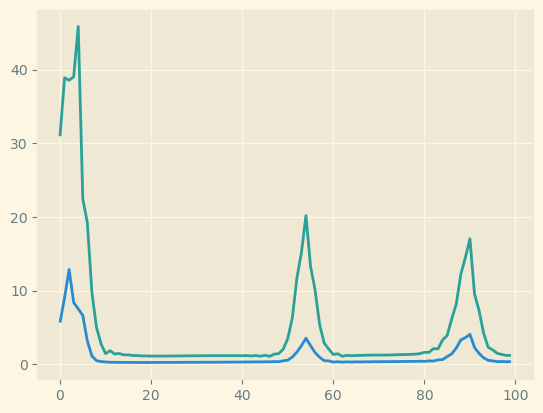

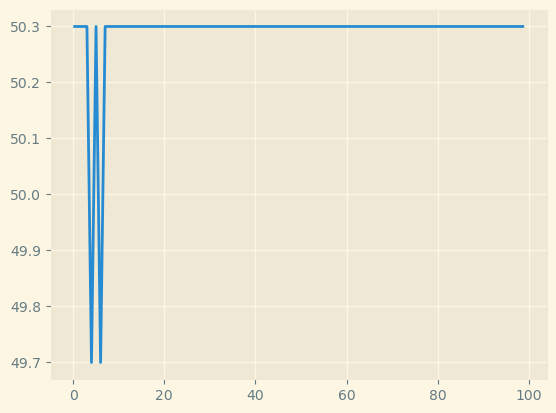

In [692]:
rnn = RNN(10, seq_len, 2)
epochs = 100
y_hat = rnn.forward(X_train)
y_pred = np.zeros_like(y_hat)
y_pred[np.arange(y_hat.shape[0]), np.argmax(y_hat, axis=1), 0] = 1
y_hat = y_pred
accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y_train, axis=1))

print(100*accuracy,"% accuracy before training")

dW_mean_lst, dW_max_lst, accuracy_lst = [],[],[]

for e in range(epochs):
    if ((e+1)%(epochs/10) == 0):
        print(100*(e+1)/epochs,"% completed")
    y_hat = rnn.forward(X_train)
    p,q = rnn.backward(X_train, y_hat, y_train,0.001)
    dW_mean_lst.append(p)
    dW_max_lst.append(q)

    y_pred = np.zeros_like(y_hat)
    y_pred[np.arange(y_hat.shape[0]), np.argmax(y_hat, axis=1), 0] = 1
    y_hat = y_pred
    
    accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y_train, axis=1))
    accuracy_lst.append(100*accuracy)

y_hat = rnn.forward(X_train)
y_pred = np.zeros_like(y_hat)
y_pred[np.arange(y_hat.shape[0]), np.argmax(y_hat, axis=1), 0] = 1
y_hat = y_pred

accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y_train, axis=1))
print(100*accuracy,"% accuracy after training")

plt.plot(dW_mean_lst)
plt.plot(dW_max_lst)
plt.show()
plt.plot(accuracy_lst)
plt.show()

### Why worse accuracy?

##### Because SimpleRNN in Keras has gradient clipping which I have not performed here.

### Why bad accuracy?

##### Because RNNs struggle with Exploding/Vanishing Gradients. This precisely happens when $W$ is updated.